## OLS Linear regression - Boston Housing Dataset 


#### Overview

In this notebook I will explore the basics of conducting a OLS linear regression study using the Boston Housing Dataset. I chose this dataset as it exhibits several violations of OLS regression assumptions which is ideal for learning purposes.


#### Contents

1. [Dataset Description](#s1)
2. [Exploratory Data Analysis](#s2)
3. [Building a Regression Model](#s3)
4. [Non-linear relationships between independent and dependent variables](#s4)
5. [Correlation of error terms (Autocorrelation)](#s7)
6. [Unusual Values (Outliers/High Leverage)](#s6)
7. [Multicollinearity](#s7)
8. [Final Model](#s8)

#### Order in which to Address Violations in OLS Linear Regression

In Ordinary Least Squares (OLS) linear regression, addressing violations of regression assumptions is crucial for maintaining model performance and result validity. The order in which these violations are addressed can significantly impact the outcomes. While there's no strict rule, a systematic approach is recommended.

**1 - Addressing Numerical Errors (Multicollinearity):**\
Multicollinearity is a primary concern due to its potential to create unstable systems of equations, leading to outright numerical errors. Variance Inflation Factors and examination of the "hat matrix" are used for diagnosis. Additional checks involve assessing missing values and verifying parameter identifiability.

**2 - Ensuring Representation of the Full Dataset (outliers, influential points):**\
Examining whether the output reflects most of the data or is sensitive to a small subset is crucial. Outliers and leverage are examined, with attention given to the potential influence of high-leverage data on results. If available, applying a robust alternative to the regression procedure is recommended at this stage.

**3 - Examination of Statistical Assumptions**\
After achieving numerical stability and ensuring representation of the full dataset, attention turns to statistical assumptions. This includes assessing residuals (heteroscedasticity, symmetry, distributional shape, correlation with predicted values, and autocorrelation), goodness of fit (considering interaction terms), and potential re-expression of dependent and independent variables. These considerations are prioritized in rough order of importance.


In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd  
import seaborn as sns 
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

df_features = pd.DataFrame(data=data, columns=['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT'])
df_features.drop('B', axis=1, inplace = True)
df_target = pd.DataFrame(data=target, columns=['MEDV'])
boston_df = pd.concat([df_features, df_target], axis = 1)

boston_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  LSTAT    506 non-null    float64
 12  MEDV     506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


### Boston house prices dataset description <a id='s1'></a>
**Characteristics:**  
- Number of Instances: 506 
- Number of Attributes: 13 numeric/categorical predictive. 
- Median Value (attribute 14) is usually the target.
- Attribute Information (in order):
    - **CRIM**: per capita crime rate by town
    - **ZN**: proportion of residential land zoned for lots over 25,000 sq.ft.
    - **INDUS**: proportion of non-retail business acres per town
    - **CHAS**: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
    - **NOX**: nitric oxides concentration (parts per 10 million)
    - **RM**: average number of rooms per dwelling
    - **AGE**: proportion of owner-occupied units built prior to 1940
    - **DIS**: weighted distances to five Boston employment centres
    - **RAD**: index of accessibility to radial highways
    - **TAX**: full-value property-tax rate per \$10,000
    - **PTRATIO**: pupil-teacher ratio by town
    - **LSTAT**: % lower status of the population
    - **MEDV**: Median value of owner-occupied homes in $1000's
    
    Missing Attribute Values: None
    Creator: Harrison, D. and Rubinfeld, D.L.
            
This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

### Exploratory Data Analysis <a id='s2'></a>

EDA is an important first step as it allows us to understand our data, and facilitates the discovery of any statistical issues that may affect the linear regression model output, which can then be addressed at a later stage.

A good place to start is with the distribution of the target variable. MEDV looks normally distributed but has a slight skew to the right which could be problematic when fitting the model.

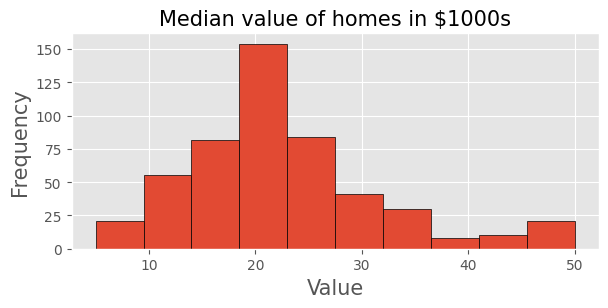

In [3]:
plt.style.use('ggplot')

# Histogram of target: MEDV     
boston_df['MEDV'].plot(kind='hist',edgecolor='black',figsize=(6,3))
plt.title('Median value of homes in $1000s', size=15)
plt.xlabel('Value', size=15)
plt.ylabel('Frequency', size=15) 
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [4]:
boston_df.loc[:,'MEDV']

0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: MEDV, Length: 506, dtype: float64

### Linearity Assumption

Next we plot each independent variable against the dependent variable to asses whether they have a linear relationship. Notice how several variables (ZN, INDUS, NOX, LSTAT, AGE, DIS) have non linear relationships with the dependent variable and only RM seems to have a clear linear relationship.

Notice also that CRIM has several extreme (outlier) values.

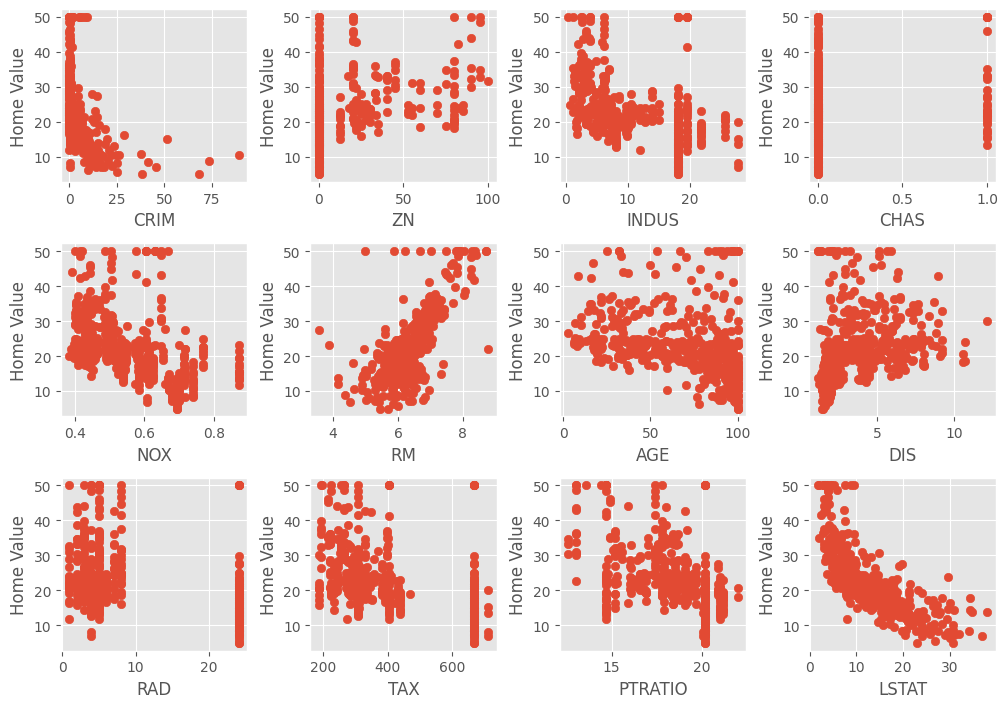

In [5]:
fig, axes = plt.subplots(3, 4, figsize=(10, 7))  # Create a 3x4 grid of subplots
axes = axes.ravel()  # Flatten the axes array for easier indexing

for index, feature_name in enumerate(df_features.columns):
    ax = axes[index]  # Select the current subplot
    ax.scatter(df_features[feature_name], df_target)
    ax.set_ylabel('Home Value', size=12)
    ax.set_xlabel(feature_name, size=12)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### Independent Variable Distribution Normality

Apart from RM all independent variables exhibit non-normal distributions. Notice also that CHAS is a binary categorical variable. Normality of independent variables is not a requirement of OLS linear regression as in reality independent variables are rarely normally distributed and OLS regression is therefore robust to different distribution types.

While it is not an model requirement for the independent and dependent variables to be normally distributed, it is still important to check their distributions, as highly skewed variables or variables with large tails of outliers can influence the distribution of residuals and make them non-normal.



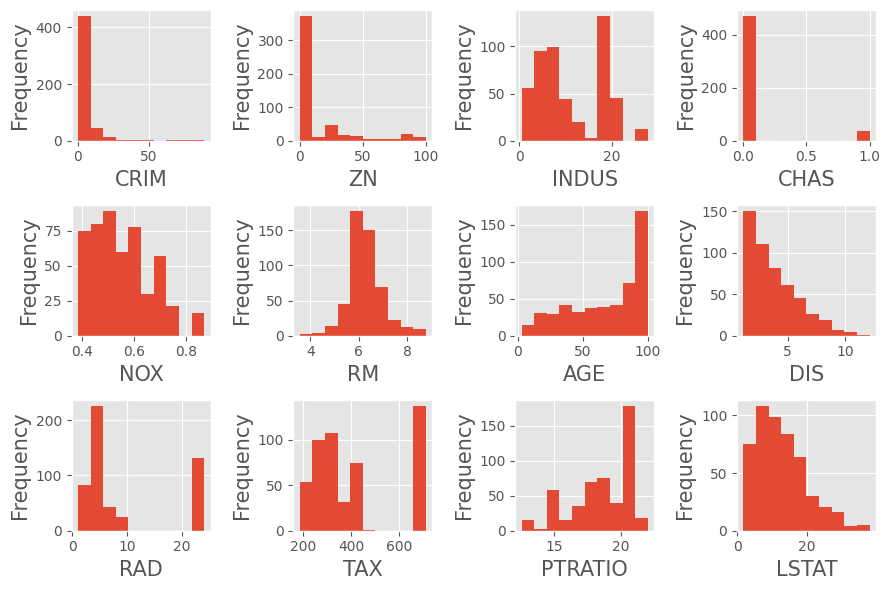

In [6]:
fig, axes = plt.subplots(3, 4, figsize=(9, 6))  # Create a 3x4 grid of subplots
axes = axes.ravel()  # Flatten the axes array for easier indexing

#Assess distribution of features
for index, feature_name in enumerate(df_features.columns):
    ax = axes[index]
    ax.hist(boston_df.loc[:, feature_name])
    ax.set_ylabel('Frequency', size=15)
    ax.set_xlabel(feature_name, size=15)

plt.tight_layout()

### Correlations

Next we examine the correlations between variables using a correlation matrix which indicates the strength and direction of a correlation. 

We would like to see relevant independent variables to be highly correlated with the dependent variable which should line up with theory based proposed relationships. For example we expect that crime would be inversely correlated with home value, number of rooms to be positively correlated with home value, etc. 

The correlation matrix also shows relationships between independant variables. Ideally independent variables would not be correlated as this violated the no collinearity assumption of OLS regression.

Using Seaborn library we can obtain a heatmap representation of the correlation matrix which makes it easier to spot correlations.

In [7]:
boston_df[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','LSTAT', 'MEDV']].corr()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,0.543993,-0.468536


<bound method XAxis.tick_top of <matplotlib.axis.XAxis object at 0x789d2da183d0>>

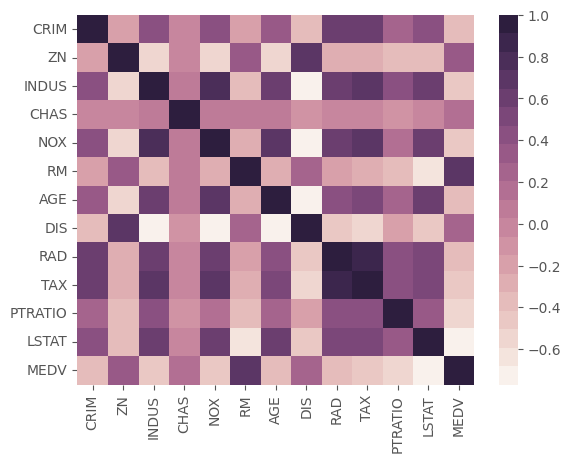

In [8]:
#Visualise correlations via correlation heatmap

heatmap =sns.heatmap(boston_df[['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATIO','LSTAT', 'MEDV']].corr(),
                     cmap=sns.cubehelix_palette(20, light=0.95, dark=0.15))
heatmap.xaxis.tick_top

From the heatmap/corr matrix we can see the only feature that is strongly correlated with our depdendent variable MEDV is RM.

## Building a Regression Model <a id='s3'></a>

Next we will construct the regression model and interpret the output.

Looking at the model output we can see that the model has:

- Statistically significant F value indicating at least one of the independent variable coefficients does not equal zero (ie the null hypothesis of all feature coefficients equalling zero is rejected).
- Large R Squared indicating that the model explains 74% of the variance in the dependent variable.


In [9]:
X = sm.add_constant(df_features)

#Model statistics
#Ensure that constant is added: represets y-intercept
model = sm.OLS(df_target, X).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          2.23e-133
Time:                        13:01:05   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.6173      4.936      8.431      0.0

Lets also assess the predictive power of the model by calculating the R-Squared predicted. Predicted R-Squared is a measure of how well the model predicts new values, it is calculated by training on the data while leaving one value out and then assessing how well the model predicts the dependent variable of the value.

For more information on predicted r squared (also known as Leave One Out Cross Validation (LOOCV)) see: https://r4ds.github.io/bookclub-islr/advantages-of-loocv-over-validation-set-approach.html

From the below code we can see that the model predicts new values with roughly the same level of accuracy as it does for the training data (ie it does not overfit to the training data).

In [10]:
from sklearn.model_selection import LeaveOneOut

y = boston_df['MEDV']

def leave_one_out_cross_val(y,x_with_const):
    # Initialize Leave-One-Out Cross-Validation
    loo = LeaveOneOut()

    # Calculate PRESS (predicted residual error sum of squares) and pred_rsq
    loo_res = []
    for train_index, test_index in LeaveOneOut().split(x_with_const): 
        X_train, X_test = x_with_const.iloc[train_index], x_with_const.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]    
        temp_model = sm.OLS(y_train, X_train)
        temp_results = temp_model.fit()    
        loo_res.append(*(y_test - temp_results.predict(X_test)))

    press = sum(np.square(loo_res))
    tss = ((y - y.mean())**2).sum() #Total Sum of Squares
    pred_rsq = 1 - (press / tss)

# Alternate calculation
#pred_rsq = 1 - np.sum(np.square(loo_res)) / np.var(y) / y.size

    print(f'Predicted R Squared: {pred_rsq}')


In [11]:
leave_one_out_cross_val(y,X)

Predicted R Squared: 0.7138159980338881


## Non-linear relationships between independent and dependent variables <a id='s4'></a>

From our EDA we saw that some independent variables are not linearly related to the dependent variable. We can examine this further by plotting our residuals against fitted values. This plot should model random error, the presence of a pattern indicates that the residuals are capturing more than just random error and that we need to modify our model to include these relationship(s) in our model.

We also plot a Q-Q plot to check the normality assumption of the residuals as this alows us to conduct hypothesis testing and confidence intervals for our model.

Plotting observed vs predicted values may also be useful. If values do not follow along the diagonal of the plot this indicates that independent variable(s) may not be linearly related to the dependent variable.

In [12]:
def ShowResidualPlots(fitted_values, residuals):
    
    plt.figure(figsize=(12, 5))

    # First subplot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    sns.scatterplot(x=fitted_values, y=residuals, color='blue')
    plt.axhline(y=0, color='red', linestyle='--')  # Add a horizontal line at y=0
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs. Fitted Values')

    # Second subplot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot of Residuals")

    # Adjust spacing between subplots
    plt.tight_layout()  
    

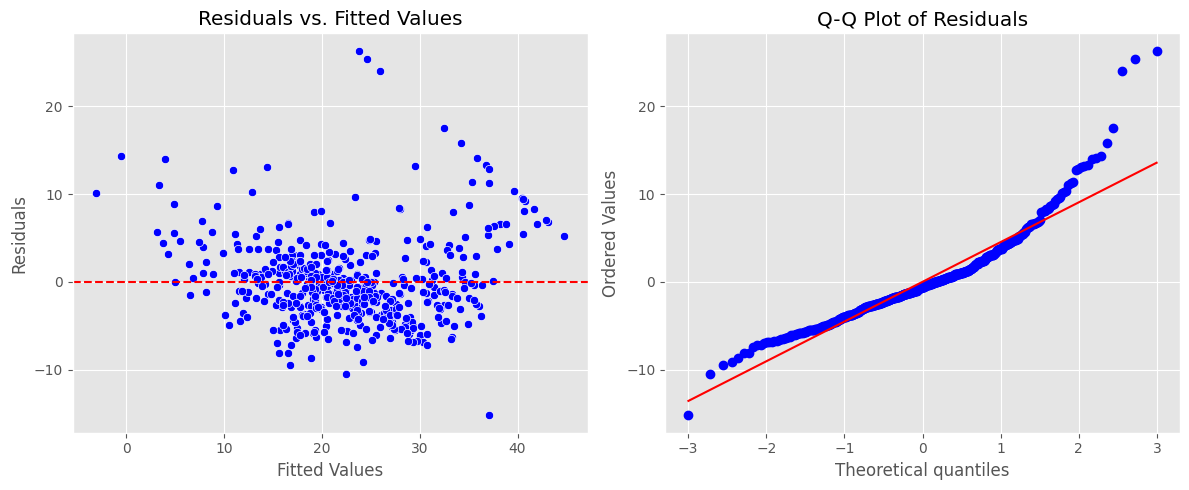

In [13]:
ShowResidualPlots(model.fittedvalues, model.resid)

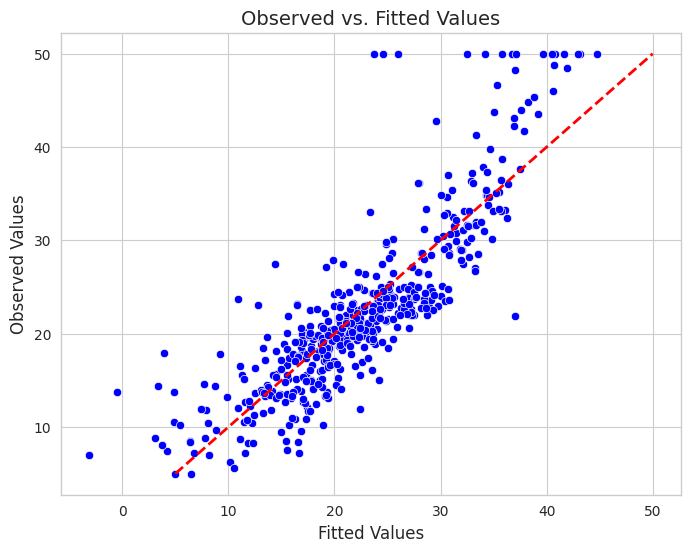

In [14]:
predicted_values = model.predict(X)

def createScatter_ObsVsFit(predicted_values, df_target, title='Observed vs. Fitted Values'):
    # Create a scatter plot of observed vs. fitted values using Seaborn
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 6))
    sns.scatterplot(y='MEDV', x=predicted_values, data=boston_df, color='blue')
    plt.xlabel('Fitted Values', fontsize=12)
    plt.ylabel('Observed Values', fontsize=12)
    plt.title(title, fontsize=14)

    # Add a diagonal line for reference (y = x)
    plt.plot([df_target['MEDV'].min(), df_target['MEDV'].max()], [df_target['MEDV'].min(), df_target['MEDV'].max()], linestyle='--', color='red', linewidth=2)
    plt.show()
    
createScatter_ObsVsFit(predicted_values=predicted_values, df_target=df_target)

The curved pattern of both the residual plot and the observed vs fitted plot indicate that the model chosen has the wrong functional form as a curve pattern is clearly visible.


Aside from visual inspection there are several quantitative tests we can use to detect heteroskedasticity:

- **White's test**: White's test is a statistical test for heteroscedasticity that can be performed using the het_white() function from the statsmodels package. This test checks whether the squared residuals are correlated with the independent variables. If the p-value of the test is less than a chosen significance level (e.g., 0.05), then heteroscedasticity may be present

- **Breusch-Pagan test**: is another statistical test for heteroscedasticity that can be performed using the het_breuschpagan() function from the statsmodels package. This test checks whether the variance of the residuals is related to the independent variables. If the p-value of the test is less than a chosen significance level, then heteroscedasticity may be present.

- **Goldfeld-Quandt test**: The Goldfeld-Quandt test is a test for heteroscedasticity that can be performed using the het_goldfeldquandt() function from the statsmodels package. This test checks whether the variance of the residuals is different between two groups of observations. If the p-value of the test is less than a chosen significance level, then heteroscedasticity may be present

In [15]:
# White's test
from statsmodels.stats.diagnostic import het_white

white_test = het_white(model.resid, model.model.exog)
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
white_res_dict = dict(zip(labels, white_test))
print(white_res_dict)

white_res_dict['LM-Test p-value'] < 0.05

{'LM Statistic': 318.3835356165268, 'LM-Test p-value': 1.5241997483499785e-27, 'F-Statistic': 7.932004971766712, 'F-Test p-value': 6.417062193387036e-50}


True

In [16]:
#Breuschpagan test
from statsmodels.stats.diagnostic import het_breuschpagan

breusch_pagan_test = het_breuschpagan(model.resid, model.model.exog)

labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
breusch_pag_res_dict = dict(zip(labels, breusch_pagan_test))
print(breusch_pag_res_dict)

breusch_pag_res_dict['LM-Test p-value'] < 0.05

{'LM Statistic': 63.302370547117, 'LM-Test p-value': 5.60657661751879e-09, 'F-Statistic': 5.874602023940098, 'F-Test p-value': 1.4084399829592488e-09}


True

In [17]:
#goldfeltd quant test steps:

X = sm.add_constant(df_features)

from statsmodels.stats.diagnostic import het_goldfeldquandt

goldfeld_quandt_test = het_goldfeldquandt(x=X, y=df_target, idx=X.columns.get_loc('RM'), drop=0.2)
print(goldfeld_quandt_test)
print(goldfeld_quandt_test[1] < 0.05)

(1.4616901290216648, 0.007079347480254363, 'increasing')
True


When considering which test to use to detect heteroskedasticity keep in mind:

**Each diagnostic test has its own set of assumptions**:
- Some tests may be more sensitive to violations of assumptions than others.
- Example: Goldfeld-Quandt assumes proportional error variances, while Breusch-Pagan assumes error variances related to independent variables.

**Magnitude of P-Value:**
- If one test shows a significant p-value while others don't, consider the magnitude**:
- A p-value close to the significance level may be borderline significant.
- A much smaller p-value provides stronger evidence of heteroscedasticity.

**Sample Size Matters:**
- Power of diagnostic tests depends on sample size
- Small sample sizes may lack the power to detect heteroscedasticity even if present.
- Visual inspection of residuals or robust regression methods may be more suitable in such cases.

**Use Caution with Diagnostic Tests:**
- Diagnostic tests are not foolproof
- Combine results with visual inspection of residuals and robust regression methods.
- The choice of method depends on the specific situation and research question.

As no heterosckedasticity is a requirement for OLS regression in practice we are required to remedy/minimise this, however we will not address this as it is an advanced topic and goes beyond the scope of basic regression analysis.


## Correlation of error terms (Autocorrelation) <a id='s5'></a>

Next we look at the correlation of the error term. Correlated error terms reduces the precision of OLS estimates (under estimation of standard error and coefficient p values). When error terms are correlated the fits vs residual plots often appears funnel shaped.

To check the independence of errors assumption we can plot each independent variable against the residuals. If independence is present then the plot will display random variation. The plots below clearly do not display random variation and hence we can say the independence of errors assumption of ols regression is violated. In particular LSAT seems to be non linearly correlated with the residual values.

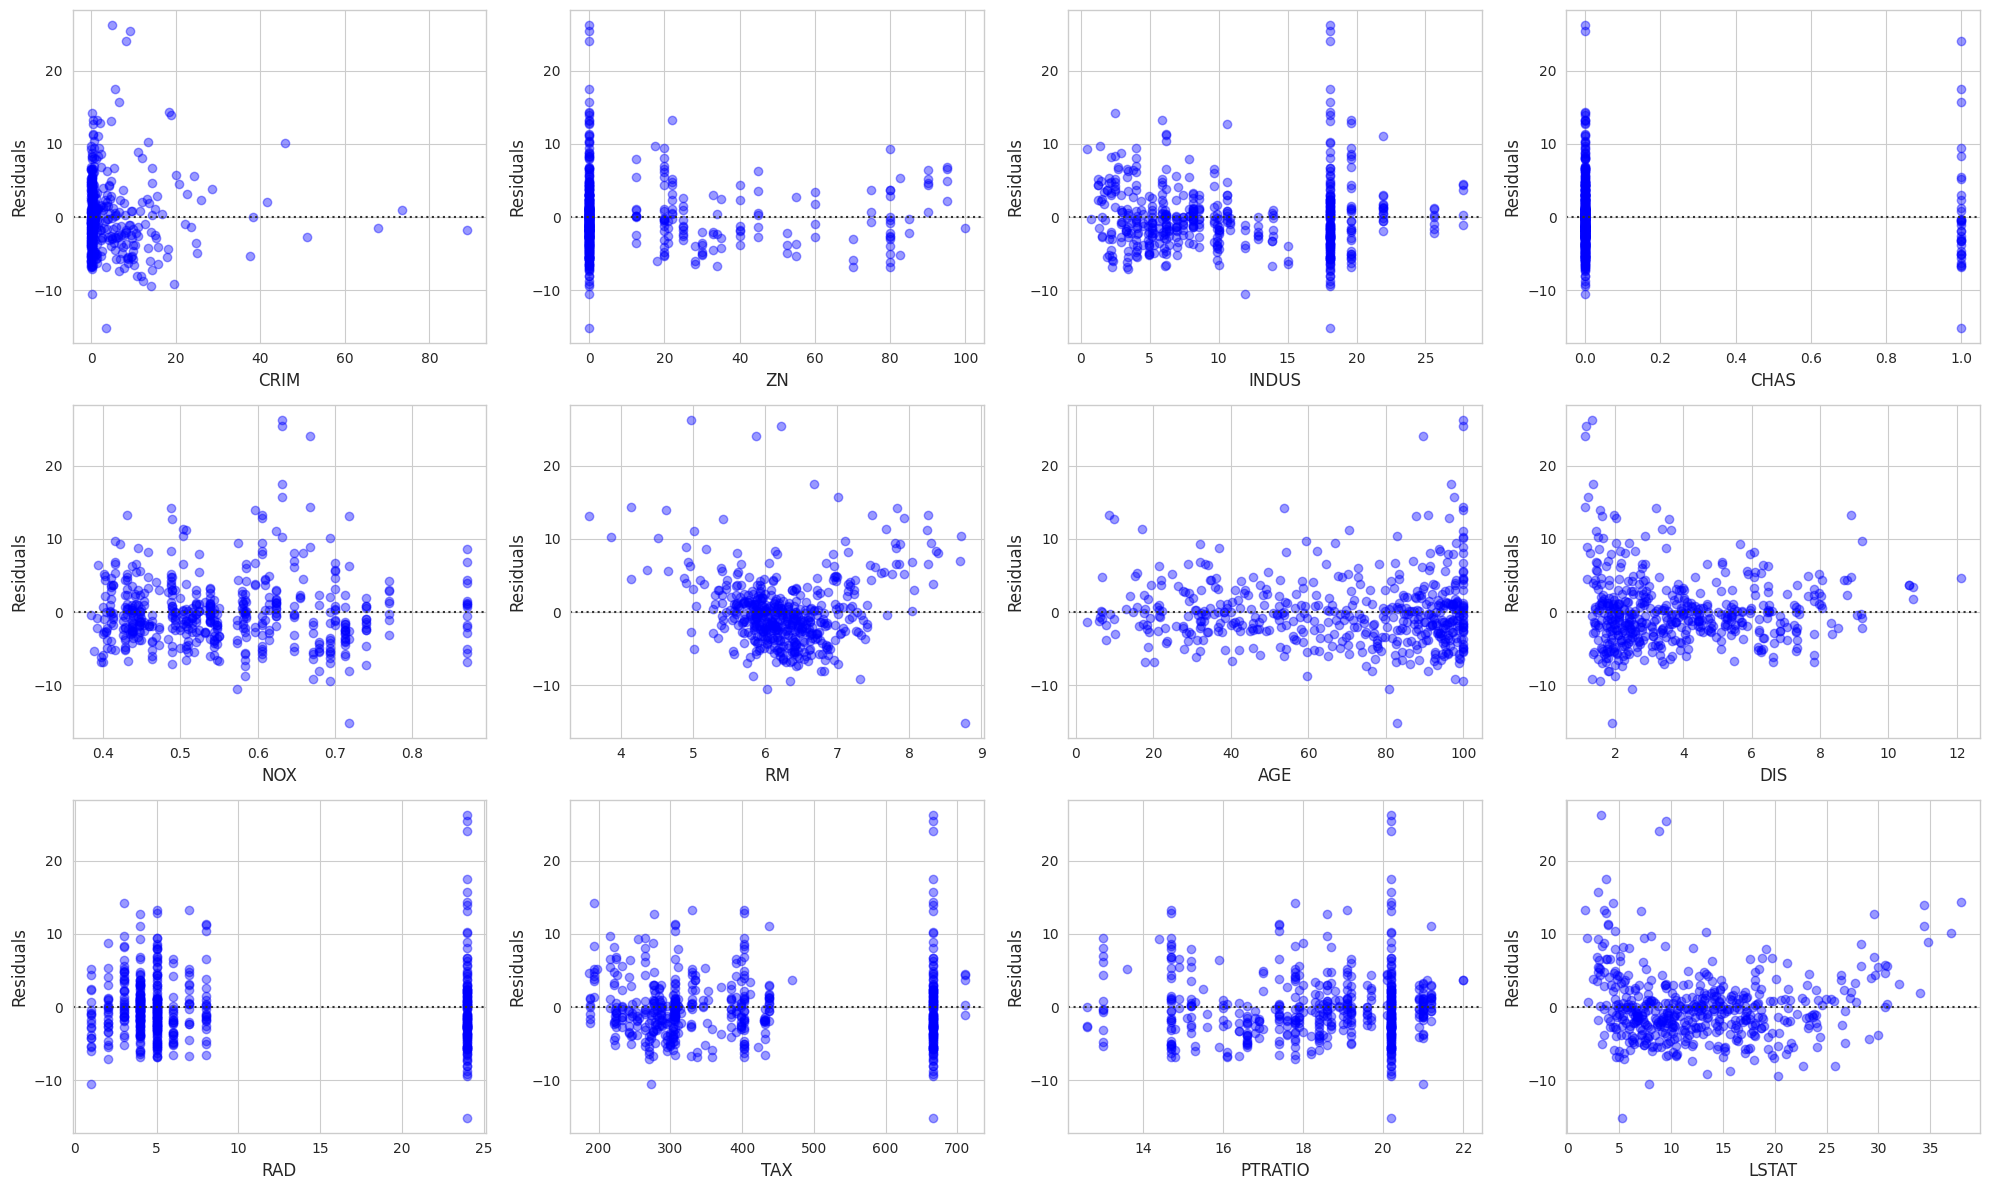

In [18]:
residuals = model.resid

fig, axes = plt.subplots(3,4, figsize=(20,12))
axes = axes.ravel()

for index, feature_name in enumerate(df_features.columns):
    ax = axes[index]
    ax = sns.residplot(x=boston_df[feature_name],y=residuals, ax=ax, scatter_kws={'alpha':0.4}, color='blue')
    ax.set_ylabel('Residuals')
    
plt.tight_layout()

## Unusual Values (Outliers/High Leverage) <a id='s6'></a>

As OLS regression looks to minimise squared residuals this makes it susceptible to outlier values. This problem can affect coefficients, p-values, predicted values, and R-squared values. Consequently, analysts must know how to identify these problematic observations, assess their influence, and know when it is appropriate to remove observations from the model fitting process.

There are two primary modes in which an observation can be unusual, outliers and high leverage observations.
- **Outliers** are values that have particularly large residual values as they do not fit the pattern of the data. We can detect them by using studentised residuals or by looking at the regression plot for single variable models.
-  **High leverage** points have an unusual value for an independent variable. They’re called leverage points because a single observation can dramatically affect the model.

Not every outlier or high leverage data point strongly influences the regression analysis. An **influential point** is an observation whose removal from the data set would cause a large change in the estimated regression model coefficients. We can think of an influential point as being both an outlier and having high leverage.

Whether or not to remove influential points from a linear regression model depends on the specific context and goals of the analysis: 

- **Predictive accuracy**: If the goal of the analysis is to make accurate predictions, then removing influential points may be beneficial. Influential points can have a large impact on the regression model, leading to biased estimates of the regression coefficients and reduced predictive accuracy

- **Sample size**: If the sample size is small, then removing influential points can lead to a loss of information and a reduction in the sample size, which can reduce the power of the statistical analysis

- **Data quality**: If the influential points are due to errors in the data, then removing them may improve the quality of the data and the accuracy of the analysis

- **Ethical concerns**: If removing influential points can be seen as data manipulation and can raise ethical concerns, then it may be better to keep them in the analysis

In [19]:
# Identify high leverage points
influence = model.get_influence()

# first we identify outlier points with residuals that are > 3 standard deviations away from the mean
resid_studentized_internal = influence.resid_studentized_internal
outliers = np.where(abs(resid_studentized_internal) > 2)
boston_df.iloc[outliers]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
64,0.01951,17.5,1.38,0.0,0.4161,7.104,59.5,9.2229,3.0,216.0,18.6,8.05,33.0
141,1.62864,0.0,21.89,0.0,0.6240,5.019,100.0,1.4394,4.0,437.0,21.2,34.41,14.4
161,1.46336,0.0,19.58,0.0,0.6050,7.489,90.8,1.9709,5.0,403.0,14.7,1.73,50.0
162,1.83377,0.0,19.58,1.0,0.6050,7.802,98.2,2.0407,5.0,403.0,14.7,1.92,50.0
166,2.01019,0.0,19.58,0.0,0.6050,7.929,96.2,2.0459,5.0,403.0,14.7,3.70,50.0
186,0.05602,0.0,2.46,0.0,0.4880,7.831,53.6,3.1992,3.0,193.0,17.8,4.45,50.0
214,0.28955,0.0,10.59,0.0,0.4890,5.412,9.8,3.5875,4.0,277.0,18.6,29.55,23.7
225,0.52693,0.0,6.20,0.0,0.5040,8.725,83.0,2.8944,8.0,307.0,17.4,4.63,50.0
228,0.29819,0.0,6.20,0.0,0.5040,7.686,17.0,3.3751,8.0,307.0,17.4,3.92,46.7
233,0.33147,0.0,6.20,0.0,0.5070,8.247,70.4,3.6519,8.0,307.0,17.4,3.95,48.3


In [20]:
type(outliers[0])

numpy.ndarray

In [21]:
# influence.hat_matrix_diag gives leverage values
pd.Series(influence.hat_matrix_diag).describe()

count    506.000000
mean       0.025692
std        0.021498
min        0.004454
25%        0.013775
50%        0.019618
75%        0.030877
max        0.289271
dtype: float64

Text(0, 0.5, 'Studentized Residuals')

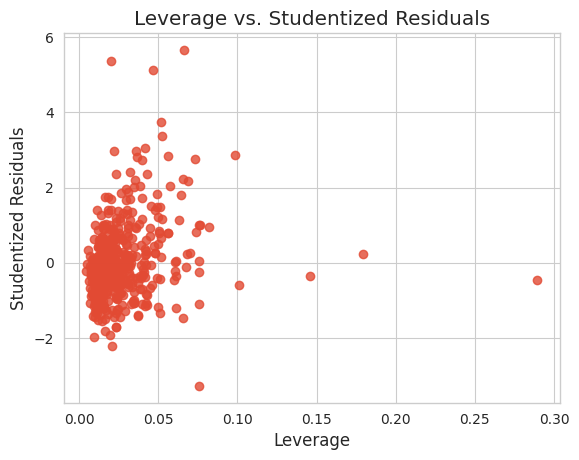

In [22]:
student_resid = influence.resid_studentized_external
(cooks, p) = influence.cooks_distance
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag

sns.regplot(x=leverage, y=resid_studentized_internal,  fit_reg=False)
plt.title('Leverage vs. Studentized Residuals')
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')

In [23]:
# Identify the leverage points that qualify as high leverage values
n = len(residuals)
p = df_features.shape[1]
threshold = 2 * (p + 1) / n
high_leverage_points = np.where(leverage > threshold)

# Identify influential points (intersection of the outliers and high leverage points)
influential_points = np.intersect1d(high_leverage_points, outliers)
influential_points

array([162, 214, 253, 364, 365, 367, 368, 369, 370, 414])

We have listed the reasons one should consider before removing points from the sample earlier, but for learning purposes lets assume we decide to remove the influential points. We will train two new regression models one without influential points (baesd on high leverage + outlier) and one without influential points (based on cook's distance) and see how they compare.

In [24]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          2.23e-133
Time:                        13:01:12   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.6173      4.936      8.431      0.0

In [25]:
df_features_wo_influential = df_features.drop(labels=influential_points)
df_target_wo_influential = df_target.drop(labels=influential_points)

X = sm.add_constant(df_features_wo_influential)

model_wo_influential = sm.OLS(df_target_wo_influential, X).fit()
print(model_wo_influential.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     139.0
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          4.40e-148
Time:                        13:01:12   Log-Likelihood:                -1415.7
No. Observations:                 496   AIC:                             2857.
Df Residuals:                     483   BIC:                             2912.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9851      4.751      6.101      0.0

In [26]:
df_features_wo_outliers = df_features.drop(labels=outliers[0])
df_target_wo_outliers = df_target.drop(labels=outliers[0])

X = sm.add_constant(df_features_wo_outliers)

model_wo_outliers = sm.OLS(df_target_wo_outliers, X).fit()
print(model_wo_outliers.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     187.2
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          3.51e-170
Time:                        13:01:12   Log-Likelihood:                -1270.8
No. Observations:                 482   AIC:                             2568.
Df Residuals:                     469   BIC:                             2622.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.8632      3.939      6.819      0.0

In [27]:
outliers_cooks = np.where(cooks > 3*np.mean(cooks[0]))[0]

df_features_wo_outliers_cooks = df_features.drop(labels=outliers_cooks)
df_target_wo_outliers_cooks = df_target.drop(labels=outliers_cooks)

X = sm.add_constant(df_features_wo_outliers_cooks)

model_wo_outliers_cooks = sm.OLS(df_target_wo_outliers_cooks, X).fit()
print(model_wo_outliers_cooks.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     174.0
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          1.13e-160
Time:                        13:01:12   Log-Likelihood:                -1183.2
No. Observations:                 464   AIC:                             2392.
Df Residuals:                     451   BIC:                             2446.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.3638      3.725      7.883      0.0

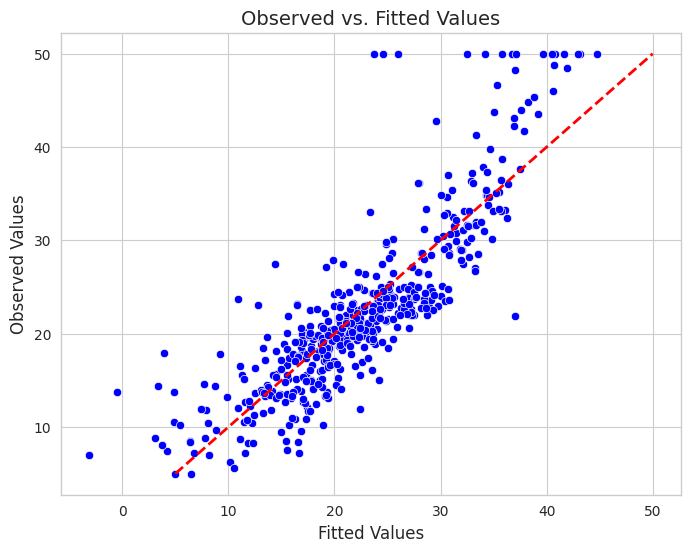

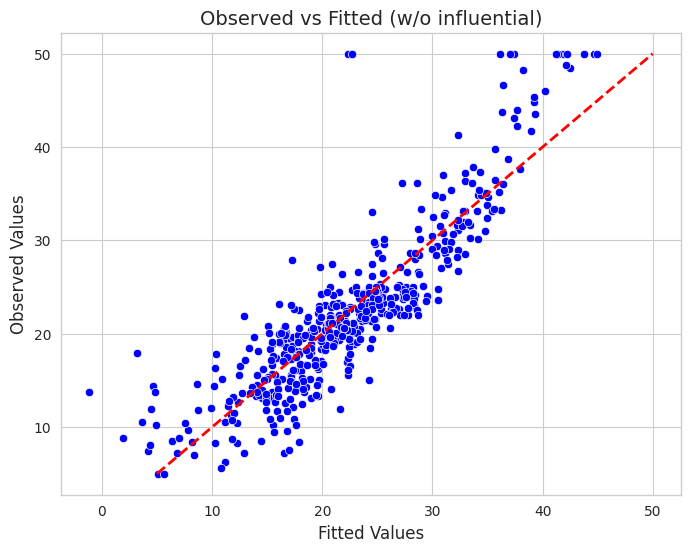

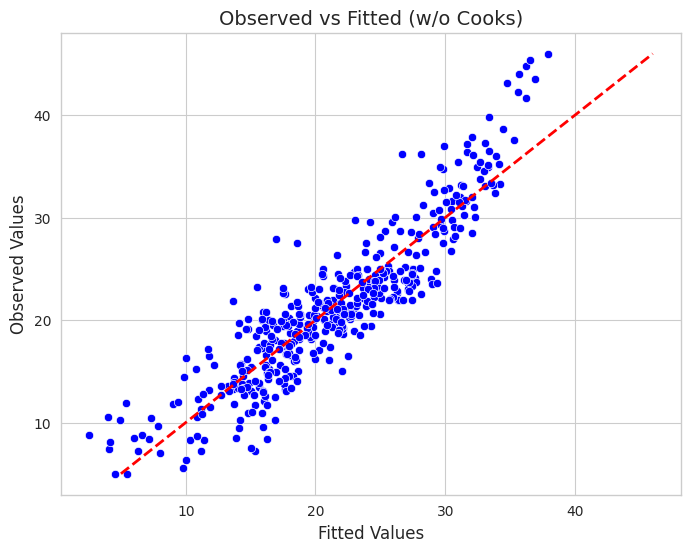

In [28]:
predicted_values_cooks = model_wo_outliers_cooks.predict(sm.add_constant(df_features_wo_outliers_cooks))
predicted_values_influential = model_wo_influential.predict(sm.add_constant(df_features_wo_influential))

createScatter_ObsVsFit(predicted_values=predicted_values, df_target=df_target )
createScatter_ObsVsFit(predicted_values=predicted_values_influential, df_target=df_target_wo_influential, title='Observed vs Fitted (w/o influential)')
createScatter_ObsVsFit(predicted_values=predicted_values_cooks, df_target=df_target_wo_outliers_cooks, title='Observed vs Fitted (w/o Cooks)')

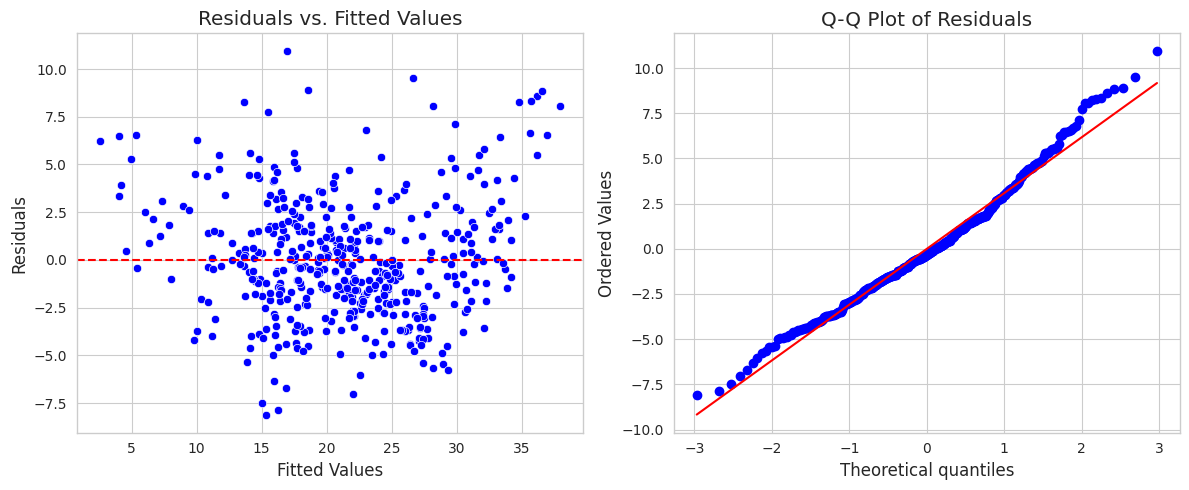

In [29]:
ShowResidualPlots(fitted_values=model_wo_outliers_cooks.fittedvalues,residuals=model_wo_outliers_cooks.resid)

#### Conclusion - Outliers/influential points

When it comes to removing outliers, it's better to remove influential points that have high leverage and are outliers rather than all outliers. This is because influential points have a disproportionate impact on the regression model, and removing them can lead to a significant improvement in the model's performance. On the other hand, removing all outliers can lead to a loss of valuable information and may negatively affect the model's ability to generalize to new data. Therefore, it's recommended to use Cook's distance as a tool to identify influential points and investigate them further before deciding whether to remove them from the dataset. An additional effect of removing outliers/influential points is that the residual plot looks much better (randomly distributed) and follows a normal distribution much more closely then before. 



## Multicollinearity <a id='s7'></a>

One of the main goals of OLS regression analysis is to isolate the relationship between each independent variable and the dependent variable. Multicollinearity occurs when independent variables are correlated with each other, and depending on the severity makes it difficult for the model to estimate the affected independent variables coefficients (they become sensitive to small changes in the model) and p values accurately.

There are two kinds of multicollinearity:
- **Structural multicollinearity**: colinearity introduced by adding additional terms into the model.
- **Data multicollinearity**: colinearity present in the data itself.

Note: Multicollinearity only affects the coefficients and p values of the affected independent variables. It does not affect the other non-correlated independent variables or model statistics.

#### Detection

Printing and observing bivariate correlations of predictors is not good enough when evaluating the existence of multicollinearity because of potential cross correlation of three or more variables.  On the flip side, in certain cases, high correlation between variables does not result in collinearity (e.g. the VIF associated with a variable is not high.)

We can use the Variance Inflation Factor (VIF) to detect multicollinearity and can be computed for each regressor by fitting an OLS model that has the regressor in question as a target variable and all other regressors as features. We can use a cutoff value to detect multicollinearity in a feature, this cuttoff value can vary but is usually 5 for small datasets or 10 for large datasets.

#### Resolution
Some texts suggest that standardization helps with multicollinearity. Standardization does not affect the correlation between regressors.

There are several approaches that can be used:
- The removal of regressors that are correlated with another regressor.
- Principal Component Analysis (PCA).
- Other regression methods which may help with the problem such as partial least squares regression or penalized regression methods like ridge or lasso regression. 
- It may be acceptable to do nothing if the precision of estimating parameters is not that important.

In this instance we will utilise the first approach.

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

x_temp = sm.add_constant(df_features)

# For each X, calculate VIF (1/(1- RSquared)) and save in dataframe
# Define function for 
def GetVIF(df):
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(df, i) for i in range(df.shape[1])]
    vif["features"] = df.columns
    vif.round(1)
    return vif

print(GetVIF(x_temp))

    VIF Factor features
0   535.526619    const
1     1.767486     CRIM
2     2.298459       ZN
3     3.987181    INDUS
4     1.071168     CHAS
5     4.369093      NOX
6     1.912532       RM
7     3.088232      AGE
8     3.954037      DIS
9     7.445301      RAD
10    9.002158      TAX
11    1.797060  PTRATIO
12    2.870777    LSTAT


A common rule of thumb is that if a variable's VIF is greater than 5, it may be considered to have a high degree of multicollinearity. Howeve the decision to drop a variable should not be solely based on this threshold.

Other points to consider are:

**Assess the practical significance:**
- Consider whether multicollinearity is practically significant.
- High VIF alone doesn't necessarily warrant removing a variable.

**Consider model and domain knowledge:**
- Think about the importance of variables in the context of your research.
- Use domain knowledge to decide which variables to keep or remove.

**Compare models:**
- Evaluate models with and without problematic variables.
- Use statistical measures (e.g., cross-validation, AIC, BIC, adjusted R-squared) to assess model performance.

**Iterate as necessary:**
- Be prepared to revisit and refine your model iteratively.
- Balance addressing multicollinearity with preserving meaningful variables.

In [31]:
# calculate VIF for model with all variables
print(GetVIF(sm.add_constant(df_features)))

    VIF Factor features
0   535.526619    const
1     1.767486     CRIM
2     2.298459       ZN
3     3.987181    INDUS
4     1.071168     CHAS
5     4.369093      NOX
6     1.912532       RM
7     3.088232      AGE
8     3.954037      DIS
9     7.445301      RAD
10    9.002158      TAX
11    1.797060  PTRATIO
12    2.870777    LSTAT


In [32]:
# Remove variable with highest VIF score > 5 (TAX) and see how it affects the VIF for other variables.
df_features_dropped_tax = df_features.drop(labels=['TAX'], axis=1)
df_features_dropped_tax = sm.add_constant(df_features_dropped_tax)
print(GetVIF(df_features_dropped_tax))

    VIF Factor features
0   529.480235    const
1     1.767349     CRIM
2     2.184172       ZN
3     3.217951    INDUS
4     1.055023     CHAS
5     4.343300      NOX
6     1.902642       RM
7     3.085756      AGE
8     3.952445      DIS
9     2.772208      RAD
10    1.787049  PTRATIO
11    2.870408    LSTAT


In [33]:
# Remove variable with second highest VIF score > 5 (TAX) and see how it affects the VIF for other variables.
df_features_dropped_RAD = df_features.drop(labels=['RAD'], axis=1)
df_features_dropped_RAD = sm.add_constant(df_features_dropped_RAD)
print(GetVIF(df_features_dropped_RAD))

    VIF Factor features
0   480.543570    const
1     1.630791     CRIM
2     2.272178       ZN
3     3.681575    INDUS
4     1.059516     CHAS
5     4.272901      NOX
6     1.859188       RM
7     3.068076      AGE
8     3.953227      DIS
9     3.351894      TAX
10    1.734159  PTRATIO
11    2.864280    LSTAT


In [34]:
# Check how removing TAX variable effects model level statistics.
model_dropped_tax = sm.OLS(df_target, df_features_dropped_tax).fit()
print(model_dropped_tax.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     120.4
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          4.68e-132
Time:                        13:01:15   Log-Likelihood:                -1510.6
No. Observations:                 506   AIC:                             3045.
Df Residuals:                     494   BIC:                             3096.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8673      4.958      8.041      0.0

In [35]:
# Check how removing RAD variable effects model level statistics.
model_dropped_RAD = sm.OLS(df_target, df_features_dropped_RAD).fit()
print(model_dropped_RAD.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                     117.9
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          1.82e-130
Time:                        13:01:15   Log-Likelihood:                -1514.3
No. Observations:                 506   AIC:                             3053.
Df Residuals:                     494   BIC:                             3103.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.7761      4.759      7.308      0.0

#### Conclusion - Multicolinearity

Notice both removing RAD and TAX brings all VIF values into the accepted range of < 5. However when we run models without each variable the model without TAX has better model statistics (higher R-squared, lower AIC and BIC) so we will remove TAX and keep RAD.

Article explaining AIC and BIC : https://medium.com/swlh/what-do-we-see-with-aic-bic-57b3e12685d

## Final model <a id='s8'></a>

After addressing model assumption violations our final model is shown below.

In [36]:
y_target = df_target_wo_outliers_cooks
x_features = df_features_wo_outliers_cooks.drop(columns=['TAX'], axis=1)

results_final = sm.OLS(endog=y_target, exog=sm.add_constant(x_features)).fit()
results_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     179.3
Date:                Wed, 13 Dec 2023   Prob (F-statistic):          4.58e-157
Time:                        13:01:15   Log-Likelihood:                -1194.5
No. Observations:                 464   AIC:                             2413.
Df Residuals:                     452   BIC:                             2463.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.5286      3.792      7.260      0.000      20.077      34.980
CRIM          -0.1137      0.027     -4.191      0.000      -0.167      -0.060
ZN             0.0235      0.010      2.403      0.017       0.004       0.043
INDUS         -0.1156      0.040     -2.909      0.004      -0.194      -0.038
CHAS           2.5562      0.682      3.746      0.000       1.215       3.897
NOX          -10.8438      2.824     -3.840      0.000     -16.394      -5.294
RM             4.0131      0.370     10.852      0.000       3.286       4.740
AGE           -0.0165      0.010     -1.676      0.094      -0.036       0.003
DIS           -1.0765      0.146     -7.389      0.000      -1.363      -0.790
RAD            0.0086      0.030      0.283      0.777      -0.051       0.068
PTRATIO       -0.7036      0.093     -7.575      0.000      -0.886      -0.521
LSTAT         -0.4485      0.042    -10.663      0.000      -0.531      -0.366
==============================================================================
Omnibus:                       20.321   Durbin-Watson:                   1.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.559
Skew:                           0.467   Prob(JB):                     1.26e-05
Kurtosis:                       3.541   Cond. No.                     2.23e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""